<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-без-использования-Bert" data-toc-modified-id="Обучение-без-использования-Bert-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение без использования Bert</a></span></li><li><span><a href="#Обучение-с-использованием-Bert" data-toc-modified-id="Обучение-с-использованием-Bert-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение с использованием Bert</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT и без BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт необходимых библиотек

In [1]:
!pip install numpy==2.2.5 pandas==2.2.3 seaborn==0.13.2 nltk lightgbm transformers spacy tqdm optuna torch -q

In [2]:
!python -m spacy download en_core_web_sm

In [3]:
RANDOM_STATE = 42

In [4]:
import random
random.seed(RANDOM_STATE)
import numpy as np
np.random.seed(RANDOM_STATE)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import re
import time
from math import ceil
import time

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer

from lightgbm             import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.tree         import DecisionTreeClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords

import optuna
import torch

import transformers
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
from tqdm.notebook import trange
import tqdm
from tqdm.auto import tqdm as tqdm_auto

import spacy
import contractions
import warnings

In [5]:
# создавние класса для стилизации вывода с помощью команды print()
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
def data_viewer(df):
    print(color.BOLD + color.BLUE + color.UNDERLINE, 'Информация по таблице')
    display(df.head(5))
    print('Количество пропусков в таблице:' + color.BOLD, df.isna().sum().sum(), color.END)
    dups = df.duplicated().sum().sum()
    print('Количество явных дубликатов в таблице:', dups)
    print()
    print(df.info())

rng = None
def set_seed(seed=RANDOM_STATE):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    global rng
    rng = np.random.default_rng(seed)

### Загрузка данных

In [6]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=False)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [7]:
data_viewer(df)

 Информация по таблице


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Количество пропусков в таблице: 0 
Количество явных дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


In [8]:
df = df.drop('Unnamed: 0', axis=1)

In [9]:
target_feature_distribution = df['toxic'].value_counts()

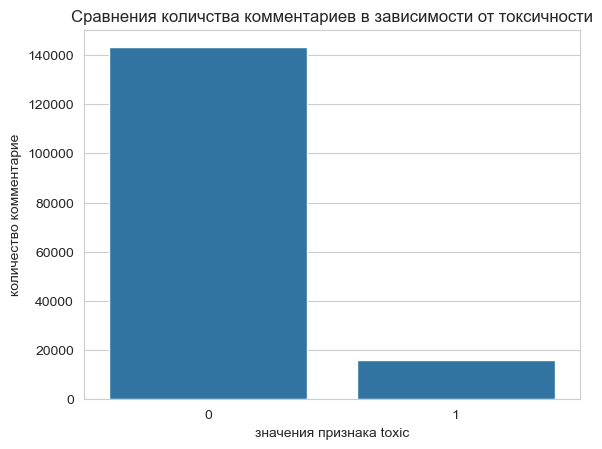

In [10]:
sns.barplot(x=target_feature_distribution.index, y=target_feature_distribution.values)
ax = plt.gca()
ax.set_title('Сравнения количства комментариев в зависимости от токсичности')
ax.set_ylabel('количество комментарие')
ax.set_xlabel('значения признака toxic')
plt.show()

Можно отметить явную несбалансированность комментариев в зависимости от целевого признака.

Для наглядности выведем по 3 токсичных и не токсичных комментария

In [11]:
class_1_indices = df[df['toxic'] == 1].index
class_0_indices = df[df['toxic'] == 0].index
np.random.seed(RANDOM_STATE) 
selected_class_1 = np.random.choice(class_1_indices, size=3, replace=False)
selected_class_0 = np.random.choice(class_0_indices, size=3, replace=False)
selected_indices = np.concatenate([selected_class_0, selected_class_1])

In [12]:
for i in range(len(selected_indices)):
    if i == 0:
        print('Не токсичные комментарии:')
    if i == 3:
        print('Токсичные комментарии:')
    print(df['text'].iloc[selected_indices[i]], '\n')

Не токсичные комментарии:
"
The opposite is true for me. As you know, until recently I could only close ""keep"" so I learned to check for these things. Another thing that can cross you up is that if an article is moved during the AFD period, then not only do you need to remove the AFD tag manually, you also have to move the oldafdfull tag from the old talk page to the new one because the Zman script doesn't follow redirects. Another thing to check for is this.   " 

What you do are doing is what you want to do.  It is not what happens anywhere else.  Its not the wishes of the others.  It is your wishes.  Please do not message me any further.  Messages will be ignored. 

arrrh, forgot signink of postink -( 

Токсичные комментарии:
Dude, get a fucking life you queer.. get a real paying job instead of e-wiki policing around, you 50 year old piece of shite... and your mom said to make your bed. 

The only nonsense I will approve is nonsense committed by 1)chaka zulu warriors. 2)anglican g

In [13]:
def clean_text(text):
    text = contractions.fix(text)
    text = text.lower().replace('\n', ' ').replace('\\', ' ')
    # Удаление последовательностей из >4 одинаковых букв (a-z)
    text = re.sub(r'([a-z])\1{4,}', ' ', text)  # Заменяет "aaaaa", "zzzzzz" и т.д. на пробел
    # удаляем все символы, кроме английских букв и пробелов
    text = re.sub(r'[^a-z\s]', ' ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [14]:
tqdm.tqdm.pandas()

In [15]:
df['clean_text'] = df['text'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████| 159292/159292 [00:08<00:00, 19694.17it/s]


In [21]:
for i in range(len(selected_indices)):
    if i == 0:
        print('Не токсичные комментарии:')
    if i == 3:
        print('Токсичные комментарии:')
    print(df['clean_text'].iloc[selected_indices[i]], '\n')

Не токсичные комментарии:
the opposite is true for me as you know until recently i could only close keep so i learned to check for these things another thing that can cross you up is that if an article is moved during the afd period then not only do you need to remove the afd tag manually you also have to move the oldafdfull tag from the old talk page to the new one because the zman script does not follow redirects another thing to check for is this 

what you do are doing is what you want to do it is not what happens anywhere else its not the wishes of the others it is your wishes please do not message me any further messages will be ignored 

arrrh forgot signink of postink 

Токсичные комментарии:
dude get a fucking life you queer get a real paying job instead of e wiki policing around you year old piece of shite and your mom said to make your bed 

the only nonsense i will approve is nonsense committed by chaka zulu warriors anglican gay priests cocksuck ers 

thou shalt be ravishe

In [22]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HONOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

### Обучение без использования Bert

In [23]:
# Загрузка модели (выполнить один раз)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [24]:
data_for_tfidf = df.copy()

In [25]:
data_for_tfidf['clean_lemm_text'] = data_for_tfidf['clean_text'].progress_apply(lemmatize_spacy)

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [19:47<00:00, 134.20it/s]


In [26]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data_for_tfidf['clean_lemm_text'], 
                                                    data_for_tfidf['toxic'],
                                                    test_size = 0.2, 
                                                    stratify=data_for_tfidf['toxic'], 
                                                    random_state = RANDOM_STATE)

In [27]:
# функция для оптимизации LogisticRegression
def objective_logreg(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    
    params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
        'penalty': penalty,
        'solver': solver,
        'max_iter': 1000,
        'class_weight': 'balanced',
        'random_state': RANDOM_STATE
    }

    # Модель
    model = LogisticRegression(**params)

    optuna_pipeline = make_pipeline(
        TfidfVectorizer(stop_words=stopwords),
        model
    )

    # кросс-валидация по F1
    score = cross_val_score(optuna_pipeline, X_train_1, y_train_1, cv=5, scoring='f1')
    return score.mean()

In [28]:
study_logreg = optuna.create_study(direction="maximize", 
                                   study_name="LogisticRegression Optimization", 
                                   sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

[I 2025-05-22 17:52:12,117] A new study created in memory with name: LogisticRegression Optimization


In [29]:
study_logreg.optimize(objective_logreg, n_trials=15)

[I 2025-05-22 17:52:36,622] Trial 0 finished with value: 0.7479468820755859 and parameters: {'penalty': 'l2', 'C': 0.8471801418819978}. Best is trial 0 with value: 0.7479468820755859.
[I 2025-05-22 17:52:57,731] Trial 1 finished with value: 0.5805009515122005 and parameters: {'penalty': 'l1', 'C': 0.004207053950287938}. Best is trial 0 with value: 0.7479468820755859.
[I 2025-05-22 17:53:19,192] Trial 2 finished with value: 0.7297238794899448 and parameters: {'penalty': 'l2', 'C': 0.2537815508265665}. Best is trial 0 with value: 0.7479468820755859.
[I 2025-05-22 17:53:47,950] Trial 3 finished with value: 0.7604487774626376 and parameters: {'penalty': 'l1', 'C': 7.579479953348009}. Best is trial 3 with value: 0.7604487774626376.
[I 2025-05-22 17:54:09,273] Trial 4 finished with value: 0.6128794927836785 and parameters: {'penalty': 'l1', 'C': 0.005337032762603957}. Best is trial 3 with value: 0.7604487774626376.
[I 2025-05-22 17:54:30,584] Trial 5 finished with value: 0.71608586533209 and

In [30]:
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', C=4.2722748162268, class_weight='balanced', random_state=RANDOM_STATE)
tf_idf = TfidfVectorizer(stop_words=stopwords)
X_train_tf_idf = tf_idf.fit_transform(X_train_1)
X_test_tf_idf = tf_idf.transform(X_test_1)
logreg_model.fit(X_train_tf_idf, y_train_1)
pred_test = logreg_model.predict(X_test_tf_idf)
f1 = f1_score(y_test_1, pred_test)
print("F1 score тестовой выборки:", f1)

F1 score тестовой выборки: 0.7667915825886422


Целевая метрика соответствует требованиям заказчика в f1_score > 0.75

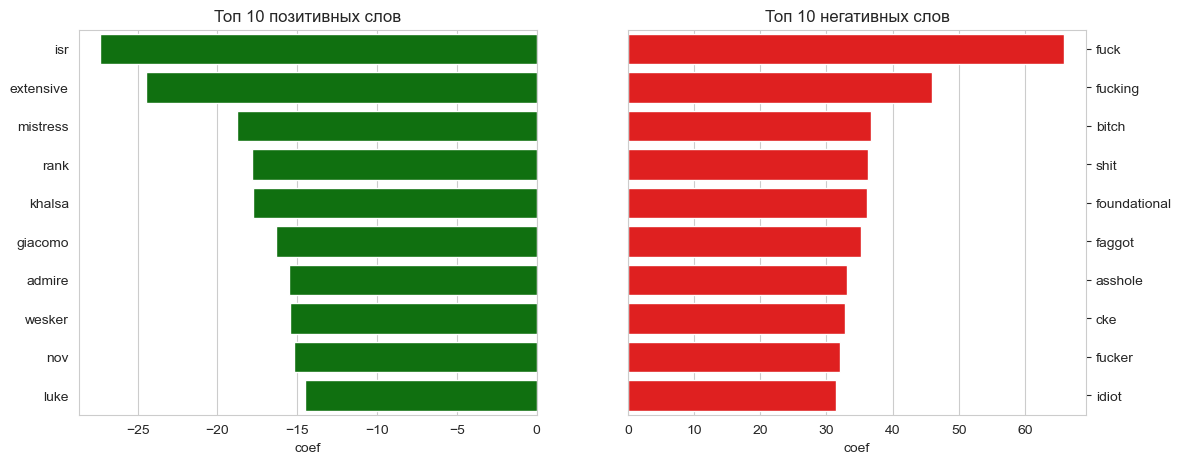

In [31]:
feature_names = tf_idf.get_feature_names_out()
coefs = logreg_model.coef_[0]


word_importance = pd.DataFrame({
    'word': feature_names,
    'coef': coefs
})

word_importance['abs_coef'] = word_importance['coef'].abs()
top_words = word_importance.sort_values('abs_coef', ascending=False).head(20)

top_pos = word_importance.sort_values('coef', ascending=True).head(10)
top_neg = word_importance.sort_values('coef', ascending=False).head(10)

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
sns.barplot(data=top_pos, x='coef', y='word', color='green', ax=axs[0])
axs[0].set_title('Топ 10 позитивных слов')
sns.barplot(data=top_neg, x='coef', y='word', color='red', ax=axs[1])
axs[1].set_title('Топ 10 негативных слов')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[1].yaxis.tick_right()

Наибольший вес для оценки негативности комментария имеет слово 'fuck'

### Обучение с использованием Bert

Поскольку токенизация и получение эмбедингов вычислительно затратная операция, выберем из данных сэмпл в 6000 строк, на которых попробуем обучить модель.

In [32]:
df_for_bert = df.sample(6000, random_state=RANDOM_STATE)

In [33]:
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
model.eval()
model.to('cpu');

In [34]:
inputs = tokenizer(list(df_for_bert['clean_text']), return_tensors="pt", truncation=True, padding=True, max_length=512)

In [35]:
def process_batches(inputs, model, batch_size=64):
    
    all_embeddings = []

    total_samples = inputs['input_ids'].size(0)

    # инициализируем прогресс-бар
    progress_bar = tqdm_auto(total=total_samples, desc='Прогресс получения CLS эмбеддингов', leave=False, dynamic_ncols=True)

    for i in range(0, total_samples, batch_size):
        # собираем батч, все тензоры на CPU
        batch = {k: v[i:i+batch_size].to("cpu") for k, v in inputs.items()}

        with torch.no_grad(): 
            outputs = model(**batch)

        # берем эмбеддинги [CLS] токена
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(cls_embeddings)

        progress_bar.update(cls_embeddings.size(0))

    progress_bar.close()

    return torch.cat(all_embeddings, dim=0)

In [36]:
# запуск обработки
embeddings = process_batches(inputs, model, batch_size=64)

Прогресс получения CLS эмбеддингов:   0%|                                                     | 0/6000 [00:00<…

In [37]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, 
                                                    df_for_bert['toxic'], 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=df_for_bert['toxic'])

In [38]:
param_grid = [
    {
        'model':[DecisionTreeClassifier(random_state=RANDOM_STATE), 
                 LGBMClassifier(class_weight='balanced', verbose=-1, random_state=RANDOM_STATE),
                 LogisticRegression(penalty = 'l1', solver='saga', random_state=RANDOM_STATE, class_weight='balanced')]
    }
]

In [39]:
embading_pipe = Pipeline([
    ('model', LogisticRegression(max_iter=1000, penalty = 'l1', solver='saga', random_state=RANDOM_STATE, class_weight='balanced'))
])

In [40]:
grid_search_class = GridSearchCV(embading_pipe, 
                                 param_grid, 
                                 cv=3, 
                                 n_jobs=-1,
                                 scoring='f1')

In [41]:
grid_search_class = grid_search_class.fit(X_train, y_train)

In [42]:
pd.DataFrame(grid_search_class.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.600731,0.023945,0.012264,0.001672,"LGBMClassifier(class_weight='balanced', random...",{'model': LGBMClassifier(class_weight='balance...,0.917431,0.911765,0.915663,0.914953,0.002367,1
1,4.092130,0.025094,0.012585,0.000715,"LogisticRegression(class_weight='balanced', pe...",{'model': LogisticRegression(class_weight='bal...,0.890756,0.882834,0.916427,0.896672,0.014338,2
2,3.585666,0.566543,0.009467,0.000341,DecisionTreeClassifier(random_state=42),{'model': DecisionTreeClassifier(random_state=...,0.864198,0.867470,0.893617,0.875095,0.013165,3


Ни одна из моделей выше не смогла на кросс-валидации достичь необходимого порога целевой метрики F1. Попробуем обучить нейронную сеть, может быть она справится чуть лучше с ограниченным количеством данных. 

П.с. В том что проблема именно в количестве данных я знаю достоверно, потому что модели постепенно показывают лучшие результаты по мере увеличения размера выборки из данных (1000 - f1 примерно 0.5, 5000 - f1 почти 0.6, 6000 - f1 почти 0.7)

In [43]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1300, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100, step=10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 40, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
    }

    model = LGBMClassifier(**params, verbose=-1, random_state=RANDOM_STATE)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return np.mean(cv_score) 

In [44]:
study_lgbm = optuna.create_study(direction='maximize', 
                                 study_name='LGBM Optimization', 
                                 sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

[I 2025-05-22 23:37:00,137] A new study created in memory with name: LGBM Optimization


In [45]:
warnings.filterwarnings("ignore", category=UserWarning, 
                        message="X does not have valid feature names")
study_lgbm.optimize(objective_lgbm, n_trials=15)

[I 2025-05-22 23:37:04,404] Trial 0 finished with value: 0.9114998552652092 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05395030966670229, 'num_leaves': 70, 'min_child_samples': 10, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 3.9676050770529883, 'reg_lambda': 0.6358358856676253}. Best is trial 0 with value: 0.9114998552652092.
[I 2025-05-22 23:37:10,884] Trial 1 finished with value: 0.9048916087607779 and parameters: {'n_estimators': 1100, 'max_depth': 4, 'learning_rate': 0.09330606024425668, 'num_leaves': 90, 'min_child_samples': 10, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 0.08179499475211674, 'reg_lambda': 0.3752055855124282}. Best is trial 0 with value: 0.9114998552652092.
[I 2025-05-22 23:37:16,214] Trial 2 finished with value: 0.9069360586653854 and parameters: {'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.04091220574443785, 'num_leaves': 30, 'min_child_

In [46]:
best_model = LGBMClassifier(**study_lgbm.best_params, verbose=-1, random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)
pred_test = best_model.predict(X_test)
f1 = f1_score(y_test, pred_test)
print("F1 score тестовой выборки:", f1)

F1 score тестовой выборки: 0.9105691056910569


Модель LGBMClassifier достаточно хорошо справилась на данных, полученных после toxic-bert. Результат на тестовой выборке более чем удовлетварительный - 0,91

## Выводы

В данной работе была проведена классификация комментариев на позитивные и негативные. В исходных данных 159292 строки с комментариями. Максимальная длина строки 5000 символов. 

Предложено 2 варианта решения в BERT и с TfidfVectorizer. 

Поскольку лемматизация и TF-IDF конечно затратны по вычислительной мощности, но не так сильно как получение эмбедингов, то весь массив данных был обработан, лемматизирован и преобразован TfidfVectorizer. Данный способ удовлетваряет требование заказчика в f1 > 0.75. Словом с наибольшим весом в пользу присовения строке класа 1 стало "fuck".

В качестве модели BERT toxic-bert, которая обучена на сэмпле из 6000 строк. На полученных эмбеддингах LGBMClassifier показал прекрасный результат на тестовой выборке в 0.91